## Process Optimization - the `Main` code 

### Initial Sampling with Latin Hypercube Sampling
- UW - MIT collaboration, led by Ethan Schwartz, Nicky Evans, Karen Yang, and Rahul Patidar
- v1. Initial sampling in Apr 2025

### Load packages and functions

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from emukit.core import ParameterSpace, ContinuousParameter, DiscreteParameter
from emukit.core.initial_designs.random_design import RandomDesign
from emukit.core.initial_designs.latin_design import LatinDesign

In [2]:
def x_normalizer(X, var_array):
    
    def max_min_scaler(x, x_max, x_min):
        return (x-x_min)/(x_max-x_min)
    x_norm = []
    for x in (X):
           x_norm.append([max_min_scaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_norm

def x_denormalizer(x_norm, var_array):
    
    def max_min_rescaler(x, x_max, x_min):
        return x*(x_max-x_min)+x_min
    x_original = []
    for x in (x_norm):
           x_original.append([max_min_rescaler(x[i], 
                                         max(var_array[i]), 
                                         min(var_array[i])) for i in range(len(x))])
            
    return x_original

def get_closest_value(given_value, array_list):
    absolute_difference_function = lambda list_value : abs(list_value - given_value)
    closest_value = min(array_list, key=absolute_difference_function)
    return closest_value
    
def get_closest_array(suggested_x, var_list):
    modified_array = []
    for x in suggested_x:
        modified_array.append([get_closest_value(x[i], var_list[i]) for i in range(len(x))])
    return np.array(modified_array)

### Parameter Optimiziton Space: 
- Web Speed (Inorganic): 0.25 - 0.55 m/min (0.01 m/min - 31 steps)
- Web Speed (Organic):  0.25 - 0.55 m/min (0.01 m/min - 31 steps)
- Solution Pump Rate (Inorganic): 80 - 200 uL/min (1 uL/min - 121 steps)
- Solution Pump Rate (Organic): 100 - 280 uL/min (1 uL/min - 181 steps)
- Molar Concentration (Inorganic): 0.8 - 1.6 M (0.05 M - 37 steps)
- Molar Concentration (Organic): 0.4 - 1.2 M (0.05 M - 37 steps)
- Relative Humidity: 11% - 44% (1% - 34 steps)
- Ambient Temperature: 20 - 65 C (5 C - 10 steps)

In [6]:
def make_linspace(start, stop, step):
    num_points = int(round((stop - start) / step)) + 1
    return np.round(np.linspace(start, stop, num_points), 4)  # round for cleaner floats

speed_inorg_var   = make_linspace(0.25, 0.55, 0.01)  # m/min
speed_org_var     = make_linspace(0.25, 0.55, 0.01)  # m/min
inkFL_inorg_var   = make_linspace(80, 200, 1)       # uL/min
inkFL_org_var     = make_linspace(100, 280, 1)      # uL/min
conc_inorg_var    = make_linspace(0.8, 1.6, 0.05)     # M
conc_org_var      = make_linspace(0.4, 1.2, 0.05)     # M
humidity_var      = make_linspace(11, 44, 1)        # %RH
temp_var          = make_linspace(20, 65, 5)        # °C

# Tracking unique values
speed_inorg_num   = len(speed_inorg_var)
speed_org_num     = len(speed_org_var)
inkFL_inorg_num   = len(inkFL_inorg_var)
inkFL_org_num     = len(inkFL_org_var)
conc_inorg_num    = len(conc_inorg_var)
conc_org_num      = len(conc_org_var)
humidity_num      = len(humidity_var)
temp_num          = len(temp_var)

# Pack into var_array for downstream normalization
var_array = [speed_inorg_var, speed_org_var, 
             inkFL_inorg_var, inkFL_org_var,
             conc_inorg_var, conc_org_var,
             humidity_var, temp_var]

x_labels = ['Speed (Inorg) [m/min]', 'Speed (Org) [m/min]', 
            'inkFL (Inorg) [uL/min]', 'inkFL (Org) [uL/min]',
            'Conc. (Inorg) [M]', 'Conc. (Org) [M]',
            'RH [%]', 'Temp [C]']


### Initial Sampling

In [9]:
parameter_space = ParameterSpace([ContinuousParameter('x1', 0, 1),
                                  ContinuousParameter('x2', 0, 1),
                                  ContinuousParameter('x3', 0, 1),
                                  ContinuousParameter('x4', 0, 1),
                                  ContinuousParameter('x5', 0, 1),
                                  ContinuousParameter('x6', 0, 1),
                                  ContinuousParameter('x7', 0, 1),
                                  ContinuousParameter('x8', 0, 1),
                                 ])

# parameter_space = ParameterSpace([DiscreteParameter('x1', np.linspace(0,1, 51)),
#                                  DiscreteParameter('x2', np.linspace(0,1, 51)),
#                                  DiscreteParameter('x3', np.linspace(0,1, 51)),
#                                  DiscreteParameter('x4', np.linspace(0,1, 51)),
#                                  DiscreteParameter('x5', np.linspace(0,1, 51)),
#                                  DiscreteParameter('x6', np.linspace(0,1, 51))
#                                  ])

### Filtering Functions

In [14]:
def check_clausius_clapeyron(humidity_vals, temp_vals):
    """
    Return boolean mask for valid points satisfying Clausius-Clapeyron constraints.
    Simplified: Ensures RH and Temp do not imply >100% saturation.
    """
    # Saturation vapor pressure approximation (T in Celsius)
    # Tetens formula: es(T) = 0.6108 * exp((17.27*T)/(T + 237.3)) [kPa]
    # RH = (actual / saturation) * 100
    # Check that vapor pressure does not exceed saturation vapor pressure
    valid_mask = []
    for RH, T in zip(humidity_vals, temp_vals):
        es = 0.6108 * np.exp((17.27 * T) / (T + 237.3))
        e = RH / 100.0 * es  # approximate check
        valid_mask.append(e <= es)
    return np.array(valid_mask)

def check_correlation(X_df, threshold=0.45):
    corr = X_df.corr(method='pearson').values
    # Zero out diagonal so we ignore self-correlation
    np.fill_diagonal(corr, 0)
    return (np.abs(corr) < threshold).all()

### Create LHS Sampling

In [19]:
# Sampling loop
max_attempts = 20000
attempts = 0
valid = False
n_samples = 8
design = LatinDesign(parameter_space)

while not valid and attempts < max_attempts:
    attempts += 1
    x_init = design.get_samples(n_samples)
    x_init_original = get_closest_array(x_denormalizer(x_init, var_array), var_array)
    df = pd.DataFrame(x_init_original, columns=x_labels)
    df_cols = x_labels

    # 1. Filter by Clausius-Clapeyron
    rh_vals = df['RH [%]'].values
    temp_vals = df['Temp [C]'].values
    mask_cc = check_clausius_clapeyron(rh_vals, temp_vals)

    if not mask_cc.all():
        continue  # skip invalid CC samples

    # 2. Filter by Pearson correlation
    if not check_correlation(df):
        continue  # correlations too high

    valid = True  # passed all tests

if not valid:
    print("No valid LHS found after max attempts.")
else:
    print(f"Valid LHS found after {attempts} attempts.")

Valid LHS found after 9205 attempts.


In [38]:
df

,Speed (Inorg) [m/min],Speed (Org) [m/min],inkFL (Inorg) [uL/min],inkFL (Org) [uL/min],Conc. (Inorg) [M],Conc. (Org) [M],RH [%],Temp [C]
0,0.53,0.31,147.0,179.0,1.55,0.75,30.0,25.0
1,0.34,0.49,177.0,134.0,1.25,1.15,17.0,30.0
2,0.42,0.53,132.0,224.0,1.05,0.45,38.0,45.0
3,0.49,0.42,162.0,269.0,1.15,1.05,21.0,50.0
4,0.31,0.34,192.0,156.0,0.95,0.85,42.0,60.0
5,0.46,0.27,87.0,201.0,1.45,0.95,25.0,55.0
6,0.38,0.38,117.0,111.0,0.85,0.55,13.0,40.0
7,0.27,0.46,102.0,246.0,1.35,0.65,34.0,35.0


##### Visualize the distribution of the initial data

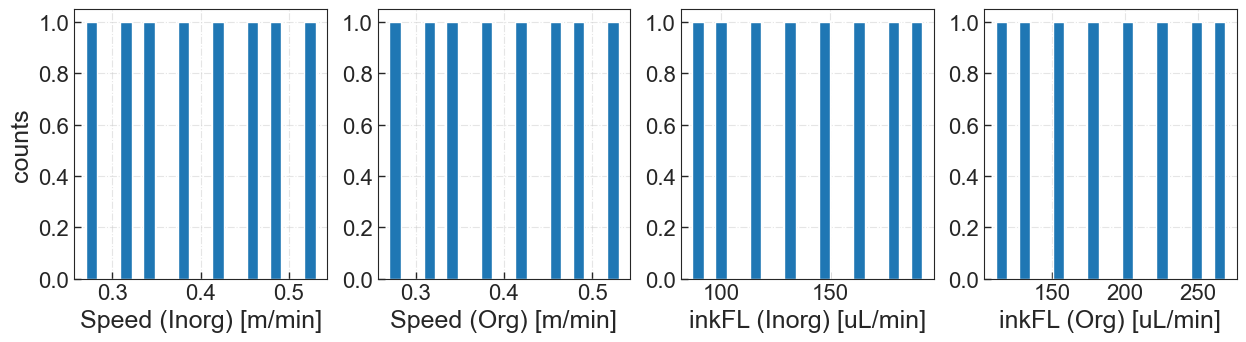

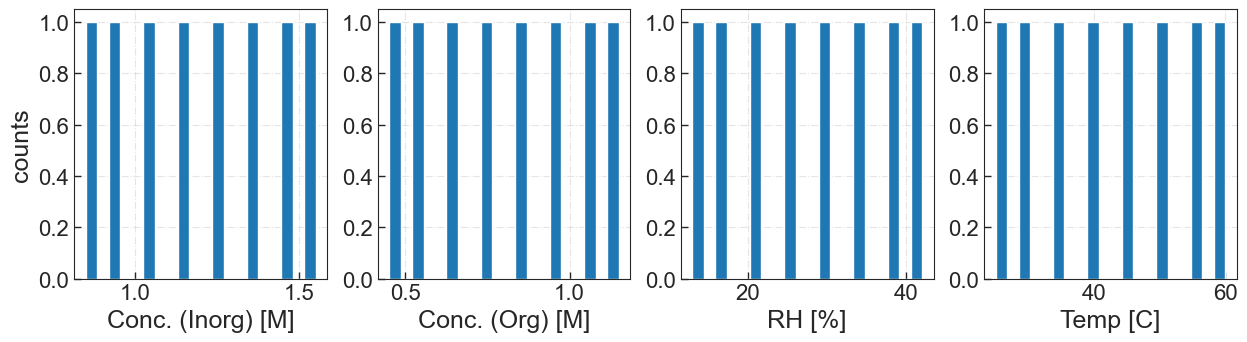

In [22]:
df_cols = x_labels
sns.set_style("ticks",{'xtick.direction': 'in', # set the style of the plot using seaborn
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})

n_col = 4 # num of columns per row in the figure
for n in np.arange(0, 6, n_col):
    fig,axes = plt.subplots(1, n_col, figsize=(15, 3.5), sharey = False)
    fs = 20
    for i in np.arange(n_col):
        if n< len(df_cols):
            axes[i].hist(df.iloc[:,n], bins = 20)
            axes[i].set_xlabel(df_cols[n], fontsize = 18)
        else:
            axes[i].axis("off")
        n = n+1      
    axes[0].set_ylabel('counts', fontsize = 18)
    for i in range(len(axes)):
        axes[i].tick_params(direction='in', length=5, width=1, labelsize = fs*.8, grid_alpha = 0.5)
        axes[i].grid(True, linestyle='-.')
    plt.show()

In [24]:
### df.to_excel("output.xlsx") 

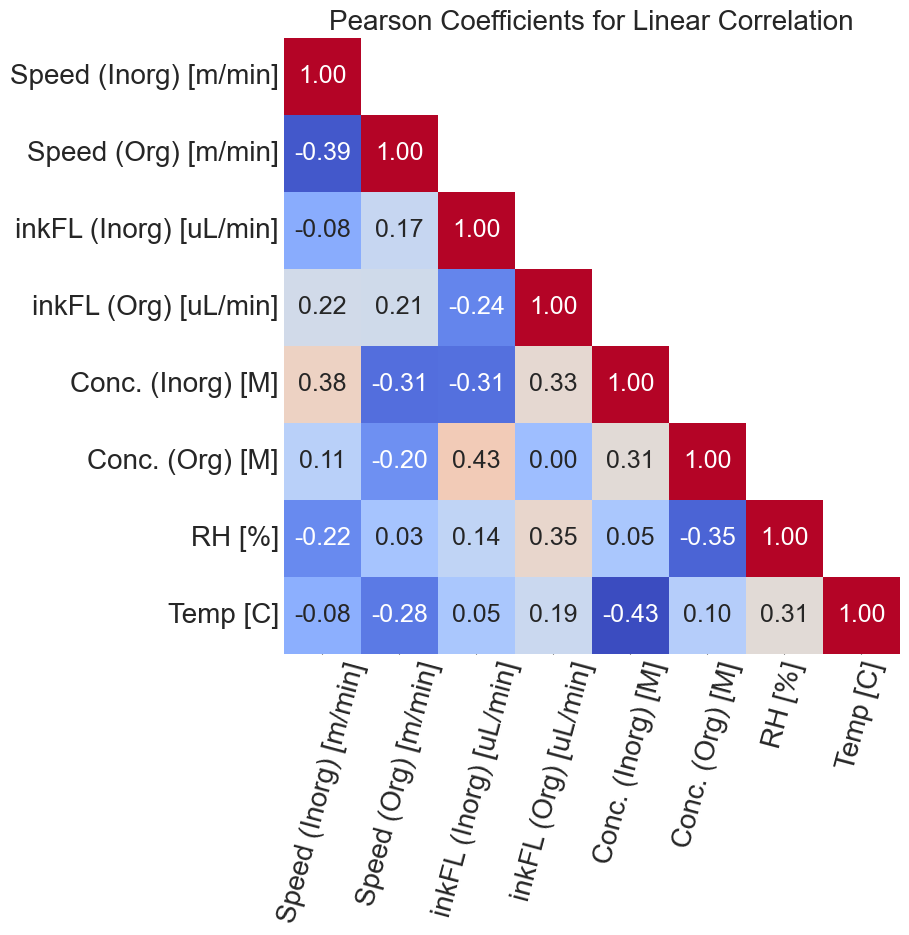

In [26]:
corr = df.corr(method='pearson')
#np.fill_diagonal(corr.values, 0)

corr.columns = x_labels
df_len = len(x_labels)
fs = 20

fig, ax=plt.subplots(figsize=(df_len,df_len))
sns.set(font_scale=1.5)
sns.set_style("ticks",{'xtick.direction': 'in',  # set the style of the plot using seaborn
                       'ytick.direction':'in',
                       'xtick.top': False,'ytick.right': False})
mask = np.triu(np.ones_like(corr, dtype=bool),k=1)
cmap = plt.get_cmap('coolwarm')
sns.heatmap(corr, mask = mask, cbar_kws={"shrink": .2}, annot=True, fmt='.2f',
          cmap=cmap, cbar=False, ax=ax, square=True)
ax.set_xlim(0, df_len)
ax.set_ylim(df_len, 0)
ax.set_title("Pearson Coefficients for Linear Correlation", fontsize = 20)
plt.xticks(rotation=75, fontsize = fs)
plt.yticks(rotation=0, fontsize = fs)
plt.show()

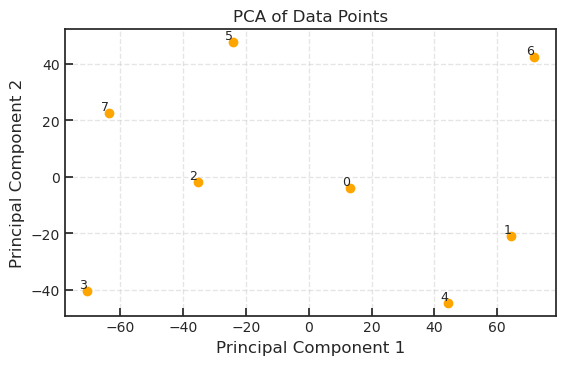

In [28]:
from sklearn.decomposition import PCA

# make sure your system has required font
plt.rcParams['font.family'] = 'DejaVu Sans'  # Also try Arial

# perform PCA
pca = PCA(n_components=2)  # Reduce to 2 components for visualization
pca_result = pca.fit_transform(df)

# plot PCA scatterplot
plt.figure(figsize=(6, 4))
plt.scatter(pca_result[:, 0], pca_result[:, 1], color='orange')
for i, (x, y) in enumerate(pca_result):
    plt.text(x, y, str(i), fontsize=9, ha='right', va='bottom')  # Add point labels
plt.xlabel("Principal Component 1", fontsize=12)
plt.ylabel("Principal Component 2", fontsize=12)
plt.title("PCA of Data Points", fontsize=12)
plt.tick_params(axis='both', which='major', labelsize=10)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

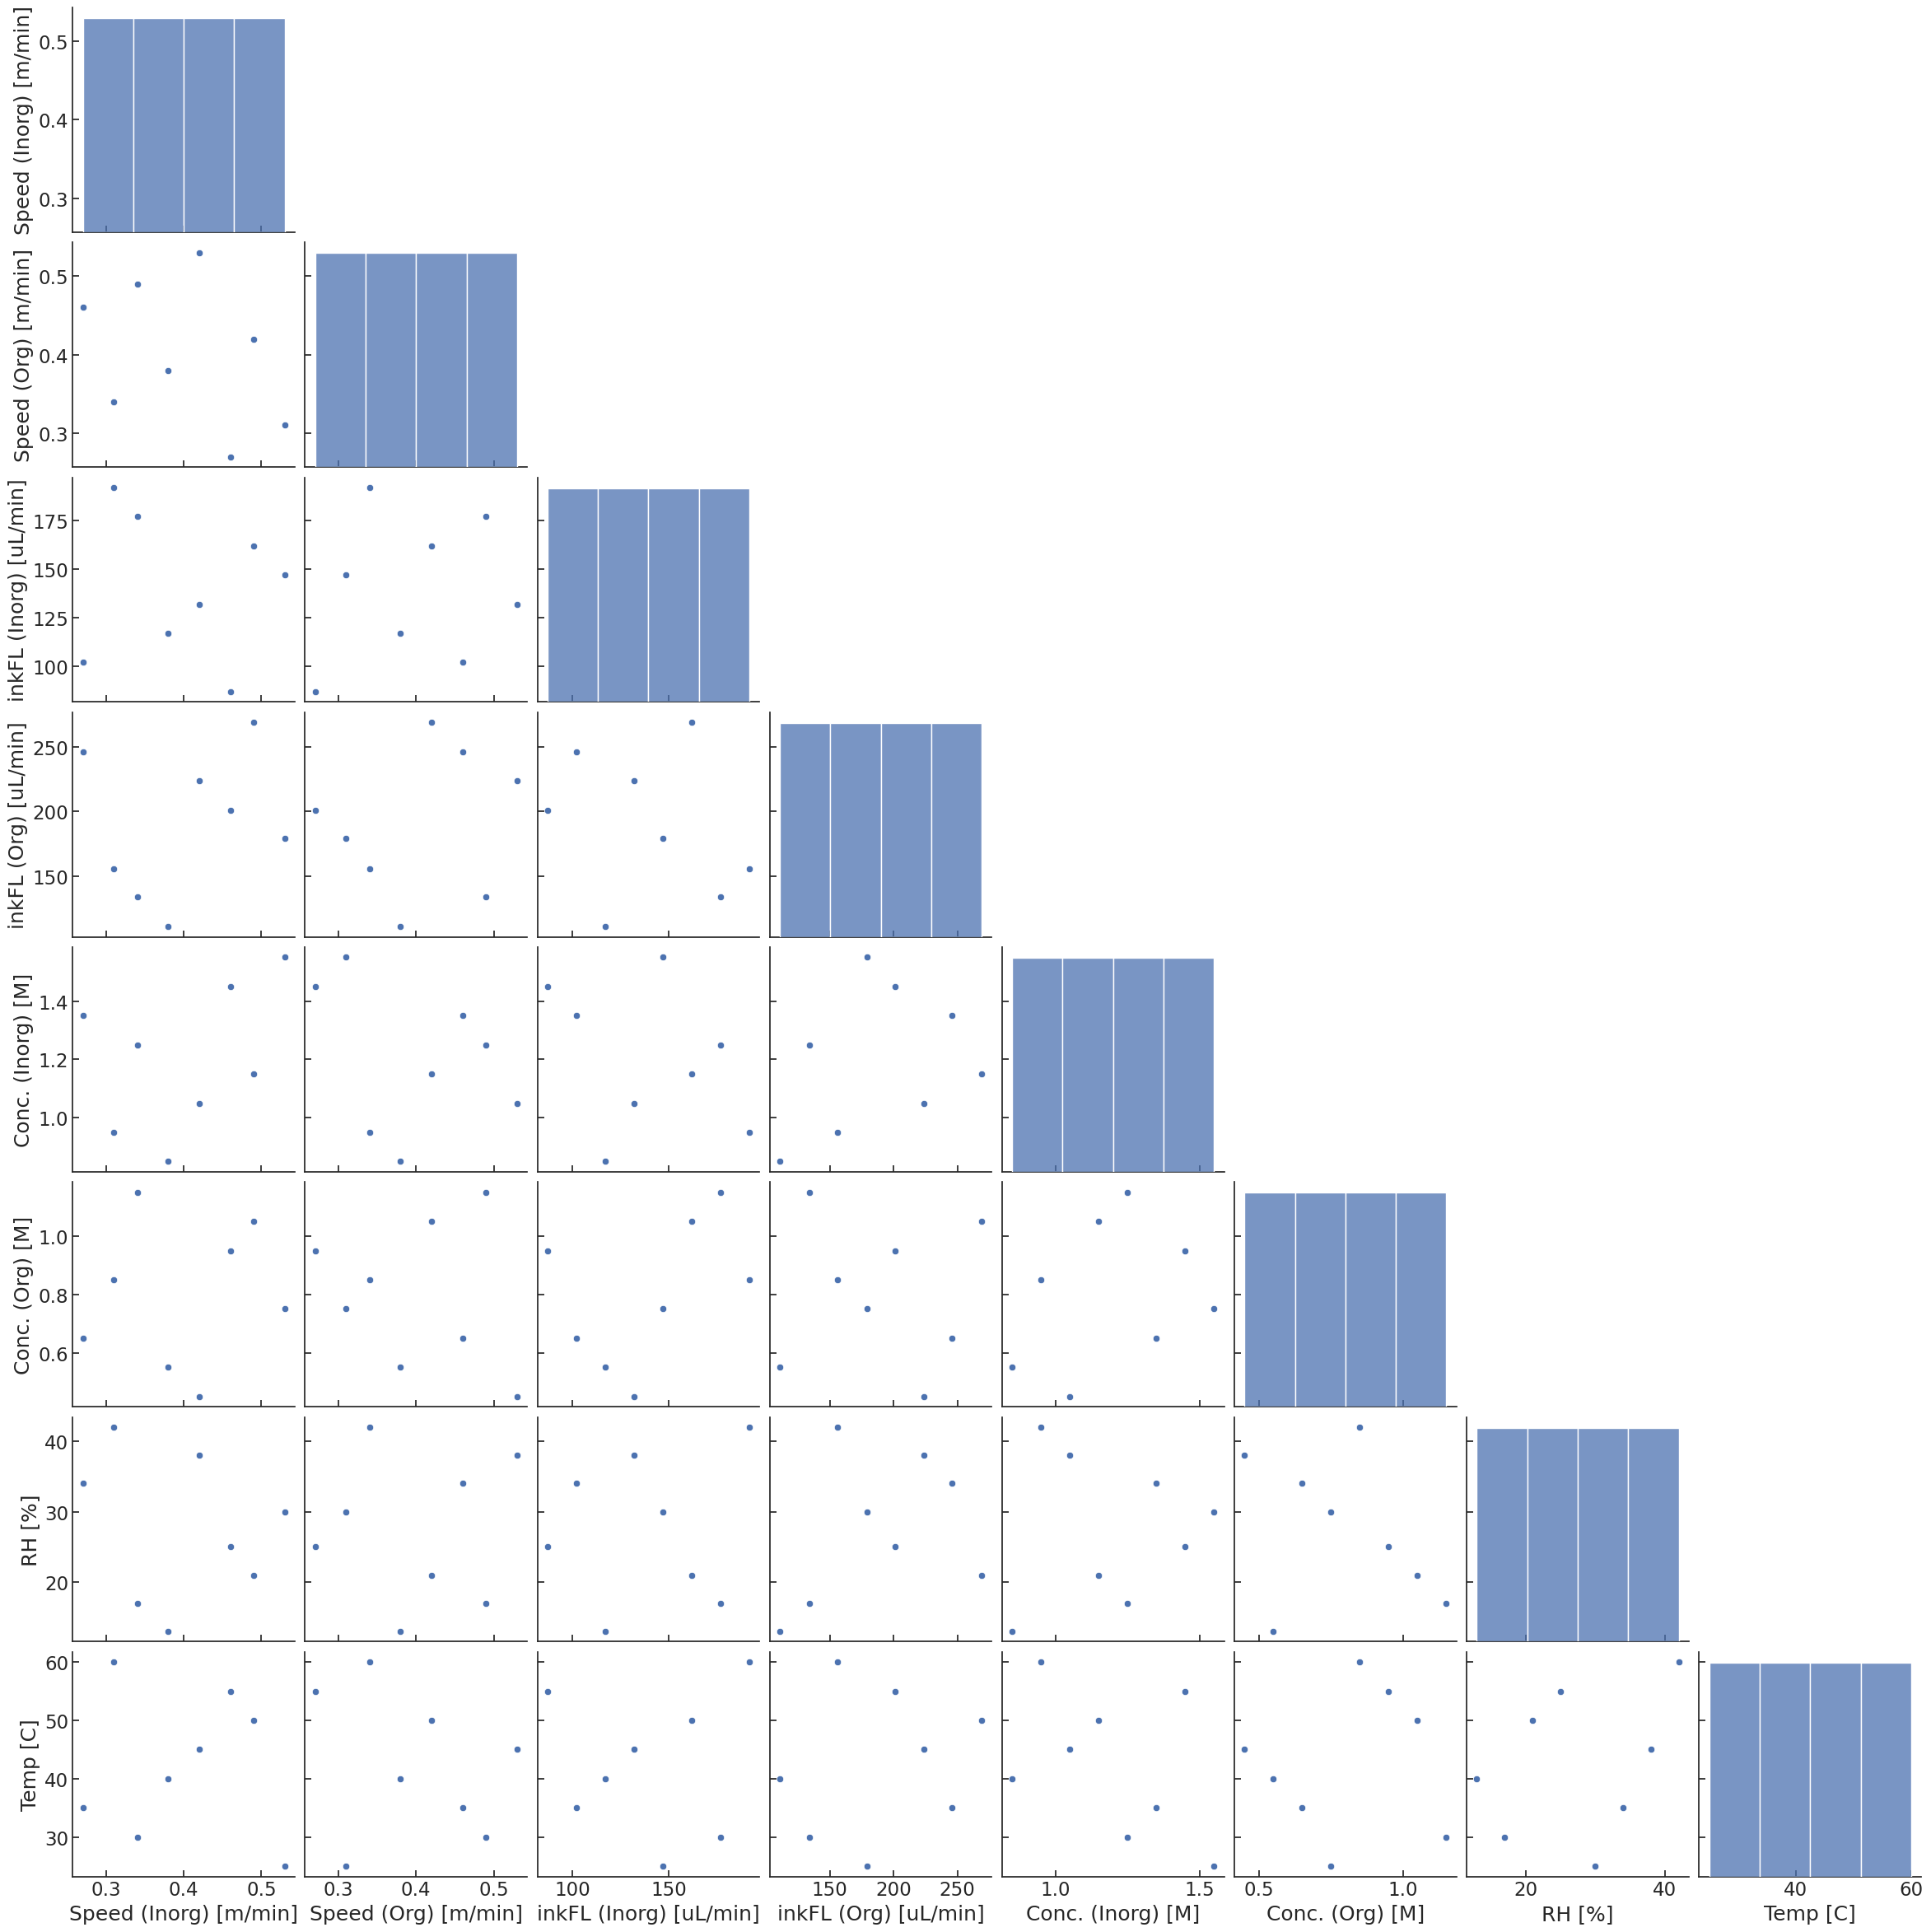

In [30]:
fig= sns.pairplot(df, height= 3)

for i, j in zip(*np.triu_indices_from(fig.axes, 1)):
    fig.axes[i, j].set_visible(False)

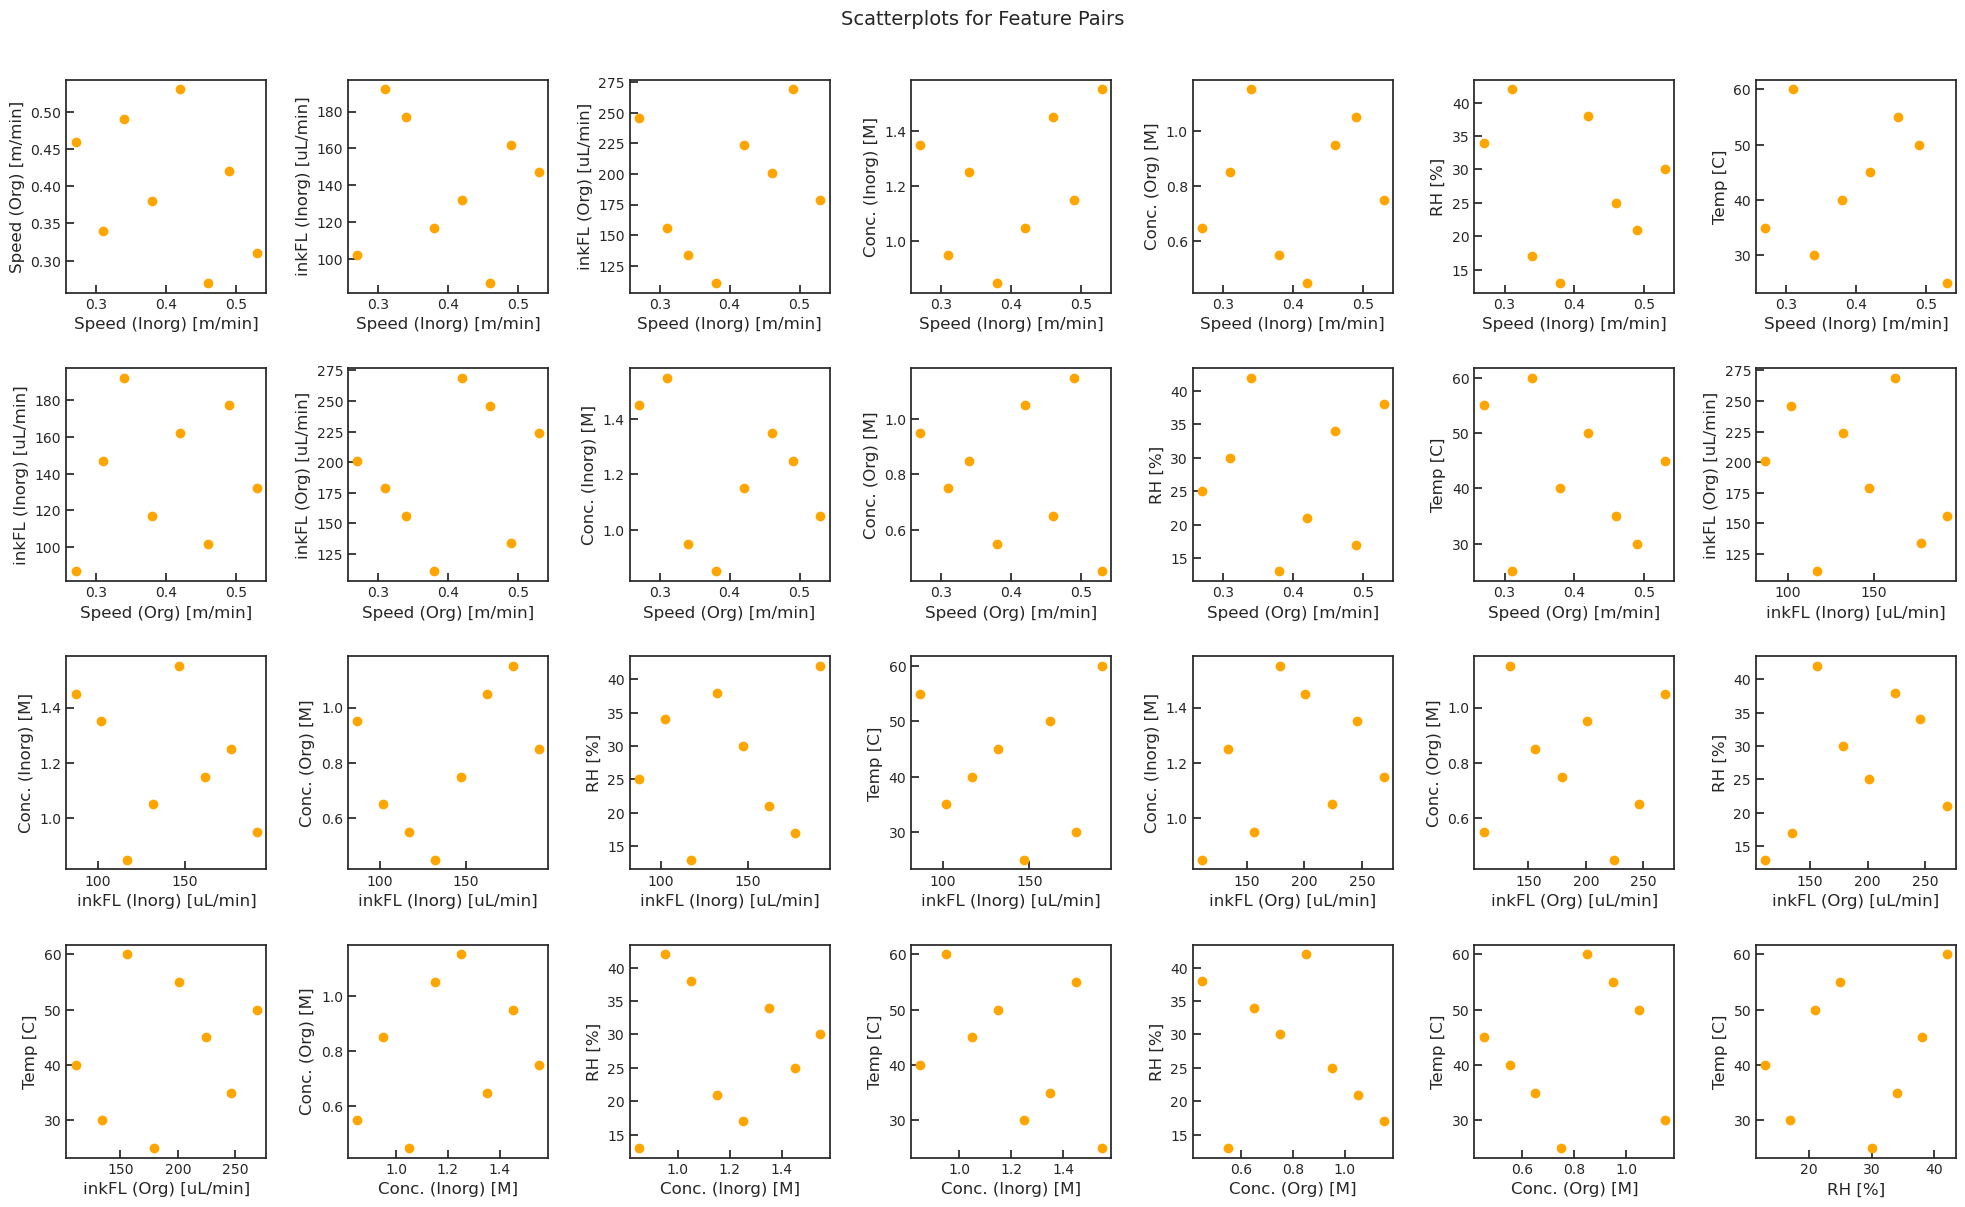

In [31]:
# make scatterplots for all feature pairs
features = df.columns
plt.figure(figsize=(20, 20))  # adjust size as needed
plot_index = 1
for i in range(len(features)):
    for j in range(i + 1, len(features)):
        plt.subplot(len(features) - 1, len(features) - 1, plot_index)
        plt.scatter(df[features[i]], df[features[j]], color='orange', edgecolor='orange')
        plt.xlabel(features[i], fontsize=12)
        plt.ylabel(features[j], fontsize=12)
        plt.tight_layout()
        plt.tick_params(axis='both', which='major', labelsize=10)
        plot_index += 1
plt.suptitle("Scatterplots for Feature Pairs", y=1.02, fontsize=14)
plt.show()

C:\Users\eschw\AppData\Local\Temp\ipykernel_121920\4185179031.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


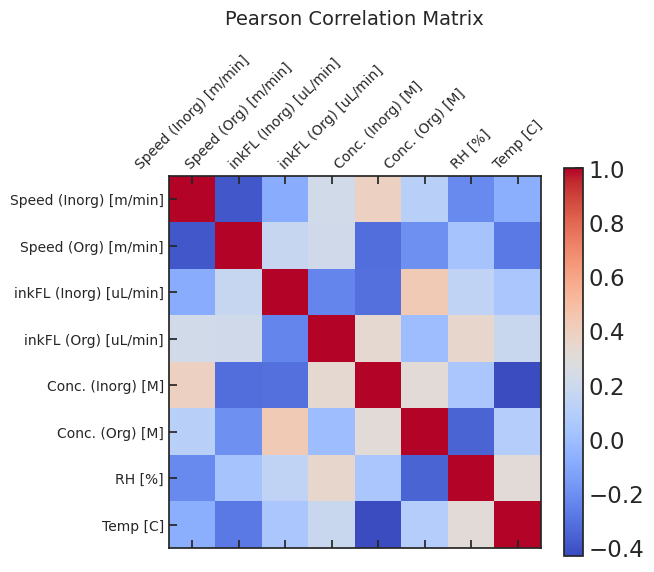

In [32]:
correlation_matrix = df.corr()
plt.figure(figsize=(6, 5))
plt.matshow(correlation_matrix, cmap='coolwarm', fignum=1)
plt.colorbar()
plt.xticks(range(len(features)), features, rotation=45, fontsize=10)
plt.yticks(range(len(features)), features, fontsize=10)
plt.title("Pearson Correlation Matrix", fontsize=14, pad=20)
plt.tight_layout()
plt.show()